# Logistic Regression Model with Diabetes Database
### Made By: Uriel Baldesco 
### Dataset from Kaggle

In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [37]:
filename = os.path.join("diabetes.csv")
df = pd.read_csv(filename)

<b>Looking inside the dataset<b>

In [38]:
print(f"first 5 rows:\n{df.head(5)}")
print(f"shape of df:{df.shape}")
print(f"the columns or features:{list(df.columns)}")
print("\n")

df.dtypes

first 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
shape of df:(768, 9)
the columns or features:['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']




Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

<b>Inspect Data and Check for Imbalance<b>
- Is there an imbalance of 0s and 1s values in the Outcome Label?
- When the mean > median, then the column is skewed:
    * The pregnancies column: mean=3.845052, median=3.000000
    * The glucose column: mean=120.894531, median=117.000000
    * <b>The insulin column: mean=79.799479, median=30.500000<b>
    * The diabetes pedigree function column: mean=0.471876, median=0.372500	
    * The outcome column: mean=0.348958, median=0
- Which feature has the highest range?
    * The column with most variation: Insulin
    * construct a vector of difference using df_summ.loc[] to find diff between max and min columns

In [39]:
df.describe(include='all')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Pregnancies: 
Max=17
Min=0
Mean=3.8

Glucose:
Max=199
Min=0
Mean=120.8

BloodPressure:
Max=122
Min=0
Mean=69

SkinThickness:
Max=99
Min=0
Mean=20

Insulin:
Max=846
Min=0
Mean=79

BMI:
Max=67
Min=0
Mean=31

Age:
Max=81
Min=21
Mean=33

* Skewed: Pregnancies, Glucose, <b>Insulin<b> , DiabetesPedigreeFunction, Age

<b>Analysis of Imbalance in the Age feature and Outcome label<b>
- There is a severe imbalance of outcomes. There is only 35% represented that do have diabetes, where as there are 65% of patients that don't have diabetes.
    * what to do when there is an imbalance in the data points?

In [41]:
no_diabetes = (df['Outcome']==0)
print(f"How many patients are not diagnosed with diabetes? {no_diabetes.sum()}")
print(f"What is the proportion of patients without diabetes? {np.sum(no_diabetes/df.shape[0])}")

print("\n")

yes_diabetes = (df['Outcome']==1)
print(f"How many patients are diagnosed with diabetes? {yes_diabetes.sum()}")
print(f"What is the proportion of patients with diabetes? {np.sum(yes_diabetes/df.shape[0])}")

How many patients are not diagnosed with diabetes? 500
What is the proportion of patients without diabetes? 0.6510416666666666


How many patients are diagnosed with diabetes? 268
What is the proportion of patients with diabetes? 0.3489583333333333


In [42]:
# column with the most range
print(f"This feature has the highest variation: {df.describe().loc['std'].idxmax()}")

# feature with the highest range
column_ranges = df.describe().loc['max'] - df.describe().loc['min']
column_range_name = column_ranges.idxmax()
print(f"This feature has the highest range: {column_range_name}")

This feature has the highest variation: Insulin
This feature has the highest range: Insulin


<b>Cleaning Data:<b>
* Check the correlation and mutual info of the features<br>
   <i>* only want features that are relevant to predicting the label -> features with highest correlation and mutual information against the label<i>
       <br>
   <i>* pairs of features are highly correlated or high mutual info are redundant and can be removed<i>
* Check for missing data points
* Check for outliers
* Check what data types are in each column 
* Visualize each column to see the outliers -> Winsorization - setting extreme outliers equal to a specified percentile of the data

In [43]:
# is there a correlation between any of the features with the label?
corrs = df.corr()['Outcome']
corrs_sorted = corrs.sort_values(ascending=False)
corrs_sorted

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

The glucose feature has the highest correlation with the label<br>
The blood pressure feature has the lowest correlation with the label
* The features with the highest correlation to the label are the most valuable
* Since skin thickness and blood pressure have pearson correlation < 0 with the Outcome, it means there is NO linear relationship between these columns and the label

In [44]:
# drop the skin thickness and blood pressure columns:
df = df.drop("SkinThickness", axis='columns')
df = df.drop("BloodPressure", axis='columns')
df.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,0,33.6,0.627,50,1
1,1,85,0,26.6,0.351,31,0
2,8,183,0,23.3,0.672,32,1
3,1,89,94,28.1,0.167,21,0
4,0,137,168,43.1,2.288,33,1


In [45]:
# are there missing values?
df.isnull()
nan_count = np.sum(df.isnull())
print(nan_count)
print('\n')
print(df.isnull().values.any())

Pregnancies                 0
Glucose                     0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


False


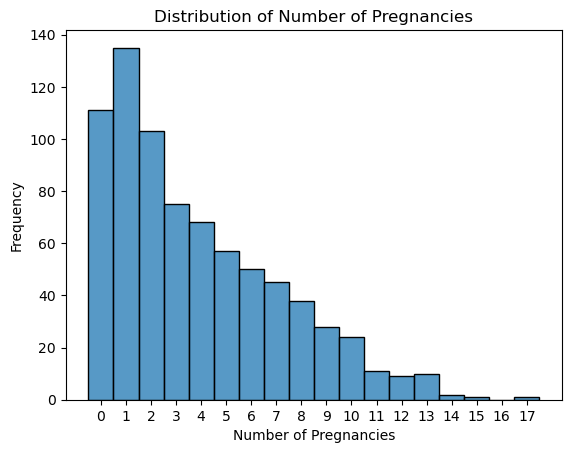

<Axes: xlabel='Age', ylabel='Count'>

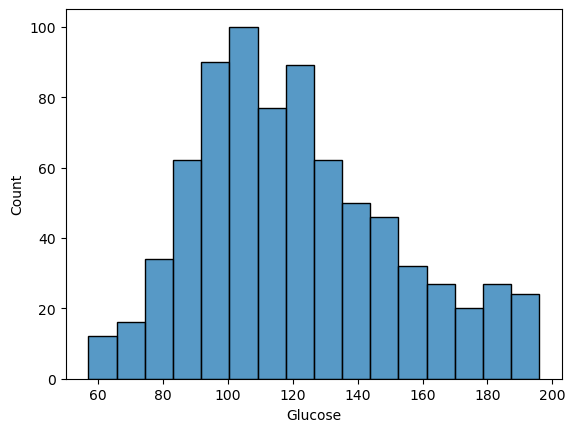

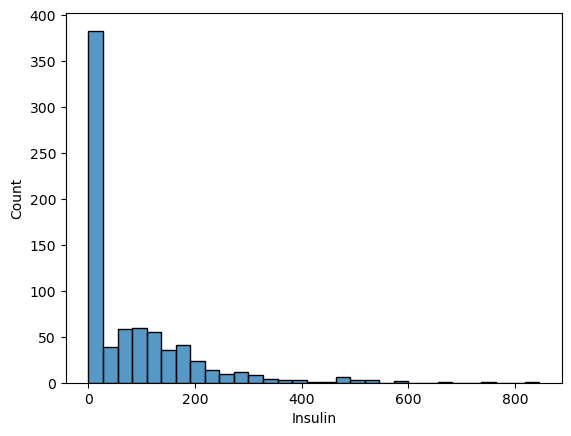

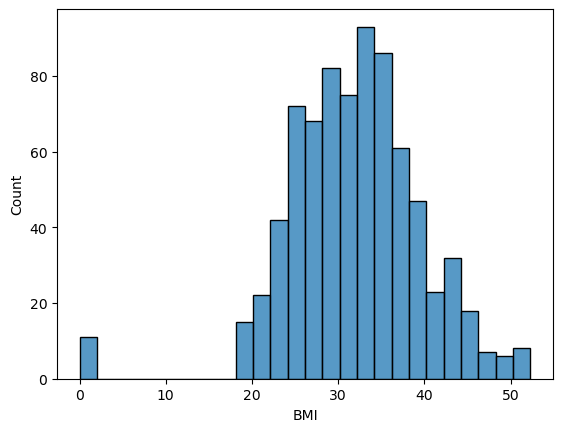

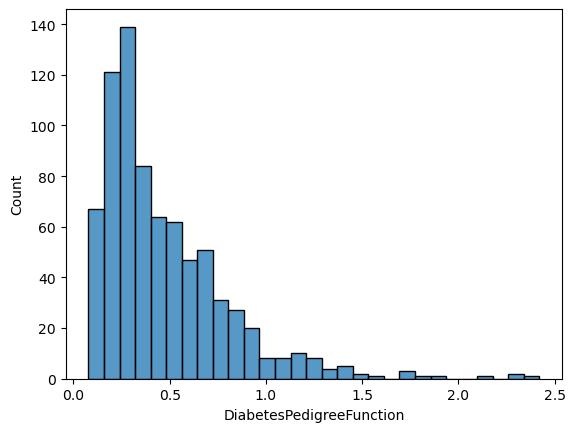

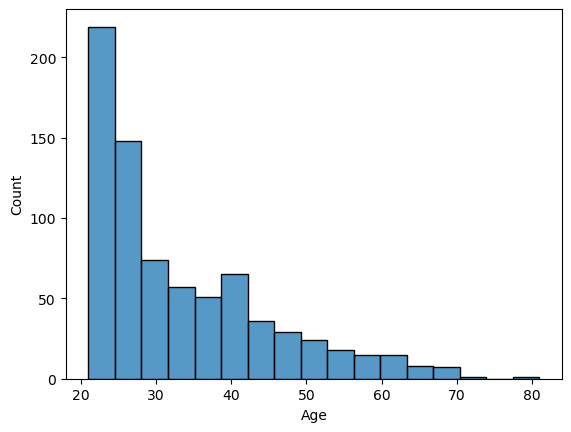

In [119]:
import seaborn as sns

plt.figure()
sns.histplot(data=df, x="Pregnancies", discrete=True, binwidth=1)
plt.xticks(np.arange(df["Pregnancies"].min(), df["Pregnancies"].max() + 1, 1))
plt.xlabel('Number of Pregnancies')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Pregnancies')
plt.show()

plt.figure()
sns.histplot(data=df, x="Glucose")
#has an outlier at 0

plt.figure()
sns.histplot(data=df, x="Insulin")
#has an outlier at 800

plt.figure()
sns.histplot(data=df, x="BMI")
#has an outlier at 0

plt.figure()
sns.histplot(data=df, x="DiabetesPedigreeFunction")

plt.figure()
sns.histplot(data=df, x="Age")


<b>Check the Outliers<b>
- Insulin has the greatest difference between the mean and median
- Winsorize the Insulin column: 
    The code cell below uses the stats.mstats.winsorize() function to add a new column to DataFrame df. The column will be named insulin-win and will contain the winsorized version of the Insulin column, with the cutoff from the 'bottom' and the cutoff from the 'top' both set at the 1% level.

In [47]:
insulin_999 = np.percentile(df['Insulin'], 99.99)
print(f"This value in insulin is the 99.99th percentile: {insulin_999}")

# winsorize insulin column bc has most skewed data
import scipy.stats as stats
df['Insulin-win'] = stats.mstats.winsorize(df['Insulin'], limits=[0.01, 0.01])
df.head(2)

This value in insulin is the 99.99th percentile: 838.1765999999925


,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin-win
0,6,148,0,33.6,0.627,50,1,0
1,1,85,0,26.6,0.351,31,0,0


In [48]:
# winsorize glucose
glucose_999 = np.percentile(df['Glucose'], 99.99)
print(f"This value in glucose is the 99.99th percentile: {glucose_999}")

import scipy.stats as stats
df['Glucose'] = stats.mstats.winsorize(df['Glucose'], limits=[0.01, 0.01])
df.head(2)

This value in glucose is the 99.99th percentile: 198.92329999999993


,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin-win
0,6,148,0,33.6,0.627,50,1,0
1,1,85,0,26.6,0.351,31,0,0


In [49]:
# winsorize BMI
BMI_999 = np.percentile(df['BMI'], 99.99)
print(f"This value in BMI is the 99.99th percentile: {BMI_999}")

import scipy.stats as stats
df['BMI'] = stats.mstats.winsorize(df['BMI'], limits=[0.01, 0.01])
df.head(2)

This value in BMI is the 99.99th percentile: 66.50940999999943


,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin-win
0,6,148,0,33.6,0.627,50,1,0
1,1,85,0,26.6,0.351,31,0,0


In [120]:
# a data point with an abs value z-score > 3 is an outlier 
df_zscores = df.select_dtypes(include=['number']).apply(stats.zscore)
df_zscores

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin-win
0,0.639947,0.868141,-0.692891,0.212677,0.468492,1.425995,1.365896,-0.715091
1,-0.844885,-1.178147,-0.692891,-0.690731,-0.365061,-0.190672,-0.732120,-0.715091
2,1.233880,2.004968,-0.692891,-1.116623,0.604397,-0.105584,1.365896,-0.715091
3,-0.844885,-1.048224,0.123302,-0.497143,-0.920763,-1.041549,-0.732120,0.137787
4,-1.141852,0.510853,0.765836,1.438731,5.484909,-0.020496,1.365896,0.809202
...,...,...,...,...,...,...,...,...
763,1.827813,-0.658454,0.870031,0.122336,-0.908682,2.532136,-0.732120,0.918080
764,-0.547919,0.023642,-0.692891,0.625664,-0.398282,-0.531023,-0.732120,-0.715091
765,0.342981,-0.008839,0.279594,-0.742354,-0.685193,-0.275760,-0.732120,0.301104
766,-0.844885,0.153565,-0.692891,-0.239027,-0.371101,1.170732,1.365896,-0.715091


<b>Setting up the features and target label:<b>

* Target Variable is 'Outcome'
* Features: Pregnancies, Glucose, Insulin, BMI, Diabetes Pedigree Function

<b>Why am I using Logistic Regression for this Diabetes Dataset?<b>
- Logistic Regression is used for low model complexity. Making predictions in medical data sets is best with logistic regression due to the small amount of patient data.

In [51]:
list(df.columns)
feature_list=['Pregnancies',
 'Glucose',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [52]:
y = df['Outcome']
X = df[feature_list]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=1234)
print(X_train.shape) #shape of train examples
print(X_test.shape) #shape of test examples

(514, 6)
(254, 6)


<b>Train<b>

In [97]:
def train_test_LR(X_train, y_train, X_test, y_test, c=1):
    model=LogisticRegression(C=c)
    model.fit(X_train, y_train)
    probability_predictions = model.predict_proba(X_test)
    l_loss = log_loss(y_test, probability_predictions)
    class_label_predictions = model.predict(X_test)
    acc_score = accuracy_score(y_test, class_label_predictions)
#     cm = confusion_matrix(y_test, class_label_predictions)
    return l_loss, acc_score, probability_predictions, class_label_predictions

In [99]:
loss, acc, probability_predictions, class_label_predictions = train_test_LR(X_train, y_train, X_test, y_test)
print('Log loss: ' + str(loss))
print('Accuracy: ' + str(acc))
print('Probability: ' + str(probability_predictions)) #continuous value 
print('Class Label Predict: ' + str(class_label_predictions)) #puts a threshold on the continuous value

Log loss: 0.4772454524662129
Accuracy: 0.7795275590551181
Probability: [[0.78739775 0.21260225]
 [0.28090833 0.71909167]
 [0.69208739 0.30791261]
 [0.64748932 0.35251068]
 [0.69362347 0.30637653]
 [0.37909493 0.62090507]
 [0.64197059 0.35802941]
 [0.86448631 0.13551369]
 [0.1096558  0.8903442 ]
 [0.88069327 0.11930673]
 [0.11417485 0.88582515]
 [0.85416164 0.14583836]
 [0.57255029 0.42744971]
 [0.97988761 0.02011239]
 [0.84162679 0.15837321]
 [0.83340891 0.16659109]
 [0.25454177 0.74545823]
 [0.49418961 0.50581039]
 [0.95438835 0.04561165]
 [0.4784781  0.5215219 ]
 [0.15906073 0.84093927]
 [0.42684334 0.57315666]
 [0.86549678 0.13450322]
 [0.34950367 0.65049633]
 [0.91108217 0.08891783]
 [0.97398507 0.02601493]
 [0.99538452 0.00461548]
 [0.06598492 0.93401508]
 [0.81063609 0.18936391]
 [0.84761783 0.15238217]
 [0.92572835 0.07427165]
 [0.90111702 0.09888298]
 [0.20855924 0.79144076]
 [0.42190946 0.57809054]
 [0.2078204  0.7921796 ]
 [0.59362556 0.40637444]
 [0.84872135 0.15127865]
 [0.

<b>Train on Different Hyperparameter Values<b>
    
<i>Smaller C regularization values are best for specify stronger regularization and a simpler model<br>Since this dataset has < 1000 examples then it is a smaller dataset and should have smaller C values<i>

In [100]:
cs = [10**i for i in range(-10,5)]
cs

[1e-10,
 1e-09,
 1e-08,
 1e-07,
 1e-06,
 1e-05,
 0.0001,
 0.001,
 0.01,
 0.1,
 1,
 10,
 100,
 1000,
 10000]

c of 1e-10:
log loss of 0.6502230427689148
accuracy score of 0.6456692913385826
c of 1e-09:
log loss of 0.6501768199088785
accuracy score of 0.6456692913385826
c of 1e-08:
log loss of 0.6497212949749583
accuracy score of 0.6456692913385826
c of 1e-07:
log loss of 0.6457280175682932
accuracy score of 0.6456692913385826
c of 1e-06:
log loss of 0.6240484431206582
accuracy score of 0.65748031496063
c of 1e-05:
log loss of 0.554893016731768
accuracy score of 0.7047244094488189
c of 0.0001:
log loss of 0.5015851892350993
accuracy score of 0.7362204724409449
c of 0.001:
log loss of 0.4806149822039102
accuracy score of 0.7480314960629921
c of 0.01:
log loss of 0.47741390935452194
accuracy score of 0.7677165354330708
c of 0.1:
log loss of 0.47527986346978307
accuracy score of 0.7755905511811023
c of 1:
log loss of 0.4772454524662129
accuracy score of 0.7795275590551181
c of 10:
log loss of 0.47868606895416527
accuracy score of 0.7755905511811023
c of 100:
log loss of 0.4788809522102201
accuracy

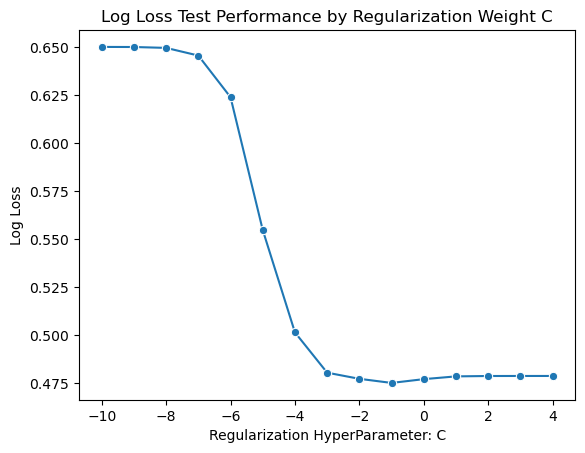

In [103]:
ll_cs = []
acc_cs = []
for c in cs:
    ll, acc,prob,class_label= train_test_LR(X_train, y_train, X_test, y_test, c)
    print('c of {0}:\nlog loss of {1}\naccuracy score of {2}'.format(c, ll,acc))
    ll_cs.append(ll)
    acc_cs.append(acc)

#visualize this
cs_log10 = np.log10(cs)

fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x=cs_log10, y=ll_cs, marker='o')
plt.title('Log Loss Test Performance by Regularization Weight C')
ax.set_xlabel('Regularization HyperParameter: C')
ax.set_ylabel('Log Loss')
plt.show()

<b>Analysis<b>
- C=1 has the highest accuracy, but C=0.1 has lower log loss = more accurate probabilistic predictions 

- C=1
- Log loss: 0.4855
- Accuracy: 0.7795
    

<h2>CONFUSION MATRIX</h2>

<p>
    <li>ANALYSIS ON FALSE NEGATIVE
    -> false negative is when you state that a patient does NOT have diabetes but they actually do
    <li>Recall: the binary classification when false negatives are worse than false positives
    <li>The confusion matrix should be computed between y_test (true labels) and the predictions made by the model on X_test.
<p>
    

Accuracy Score: 0.7795275590551181

Confusion Matrix: 


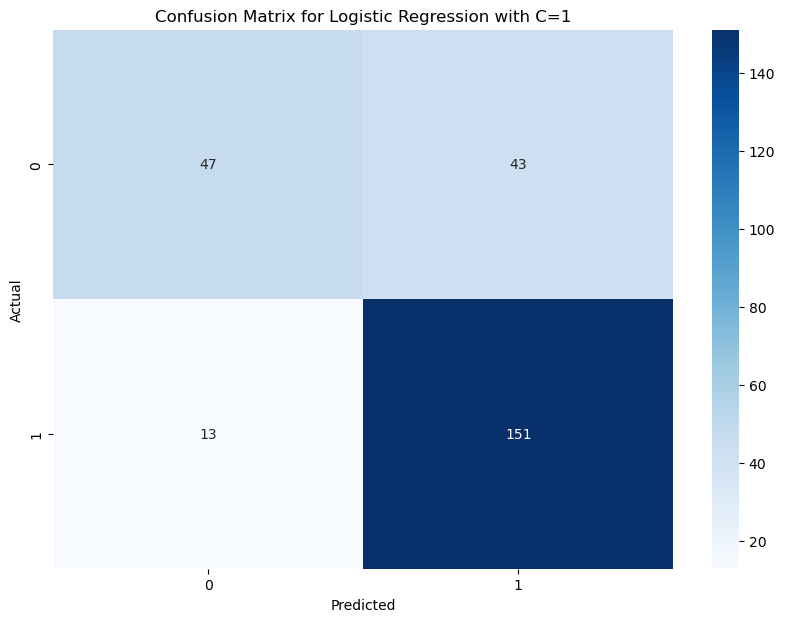

For C = 1: 
 Number of false negatives = 13


In [115]:
from sklearn.metrics import confusion_matrix, classification_report

#get class label prediction from train method
loss, acc, probability_predictions, class_label_predictions = train_test_LR(X_train, y_train, X_test, y_test)
#print(class_label_predictions)

acc_score = accuracy_score(y_test, class_label_predictions)
print('Accuracy Score: {0}\n'.format(acc_score))
print('Confusion Matrix: ')
c_m = confusion_matrix(y_test, class_label_predictions, labels=[True, False])
pd.DataFrame(
    c_m, 
    columns=['Predicted: Patient Does Not Have Diabetes', 'Predicted: Patient Has Diabetes'], 
    index=['Actual: Patient Does Not Have Diabetes', 'Actual: Patient Has Diabetes']
)

plt.figure(figsize=(10, 7))
sns.heatmap(c_m, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix for Logistic Regression with C={0}'.format(c))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Extracting and printing the number of false negatives
c=1
false_negatives = c_m[1, 0]
print(f'For C = {c}: \n Number of false negatives = {false_negatives}')

<h3>Final Changes I Made</h3>
<p>
    <li>Deleted the younger and older than 30 proportion
    <li>Winsorized Glucose and BMI
    <li>Added a Confusion Matrix to check False Negatives
<p>
                         